### Getting the mid-circuit states

Usually, we only see the final results of the execution of our circuit. However, occasionally it is helpful to know how the state of the system evolves during the execution of the circuit, particularly if we are interested in the statevector and the density matrix of the system.

 It is necessary to state that on real quantum computers, it is not possible to get the mid-circuit states (and the measurements also), so this is an excellent functionality for the simulators.

To achieve this, we will use barriers supported by Qiskit and OpenQASM standards. We will get the results of the states of the system at the location where the barrier is placed. Also, it is crucial to notice that the barriers divide the circuit for transpilation. Hence, they will behave as a separator for the states and the transpilation process.

First, we will demonstrate the usage of the barriers. Afterward, we will retrieve the desired states at the given time.


In [2]:
# For more information see the notebooks 2 & 3
from c12simulator_clients.user_configs import UserConfigs
from c12simulator_clients.qiskit_back.c12sim_provider import C12SimProvider
import os
user_auth_token = os.getenv("C12_TOKEN")
configs = UserConfigs.parse_obj({"token" : user_auth_token})
c12_simulator_provider = C12SimProvider(configs)
c12_simulator_backend = c12_simulator_provider.get_backend('c12sim-iswap')

In [3]:
from qiskit import QuantumCircuit

# For more info about Qiskit see notebook 1 and the Qiskit's documentation
circuit = QuantumCircuit(2)
circuit.h(0)
circuit.barrier() # We add a barrier at this position
circuit.cx(0, 1)
circuit.barrier()
circuit.x(1)

circuit.draw()
# Notice the barrier position in the circuit

┌───┐ ░       ░      
q_0: ┤ H ├─░───■───░──────
     └───┘ ░ ┌─┴─┐ ░ ┌───┐
q_1: ──────░─┤ X ├─░─┤ X ├
           ░ └───┘ ░ └───┘

In [4]:
# Running the circuit on C12 simulator
c12_job = c12_simulator_backend.run(circuit, shots=10000)
c12_result = c12_job.result()
c12_counts = c12_result.get_counts()
print(f"C12 simulation counts: {c12_counts}")

C12 simulation counts: {'11': 22, '01': 4804, '00': 28, '10': 5146}


1e5b13a2-b2c2-418a-baff-137476590f04


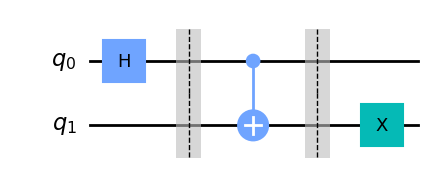

In [5]:
# Get the job_id
job_id = c12_job.job_id()
print(job_id)

# Getting all the data (transpiled circuit mainly)
orig_circuit = c12_job.get_circuit(transpiled=False)
orig_circuit.draw('mpl')

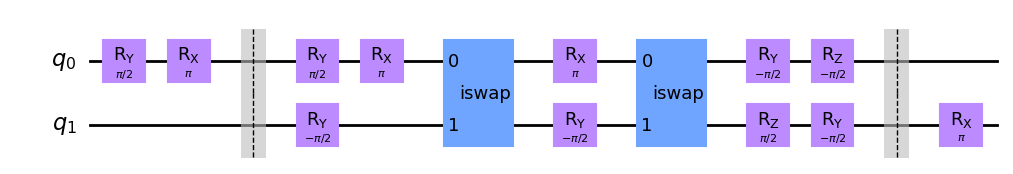

In [6]:
transpiled_circuit = c12_job.get_circuit(transpiled=True)
transpiled_circuit.draw('mpl')

#### Getting the mid-circuit states

The mid-circuit states are stored in the result object obtained from the job execution. The values can be accessed directly from the Result instance using the following command:


 `result_obj.data()['sv{NUM}']` for the state vector
 `result_obj.data()['dm{NUM}']` for the density matrix

The `{NUM}` presents the cardinal number of the barrier starting from one.

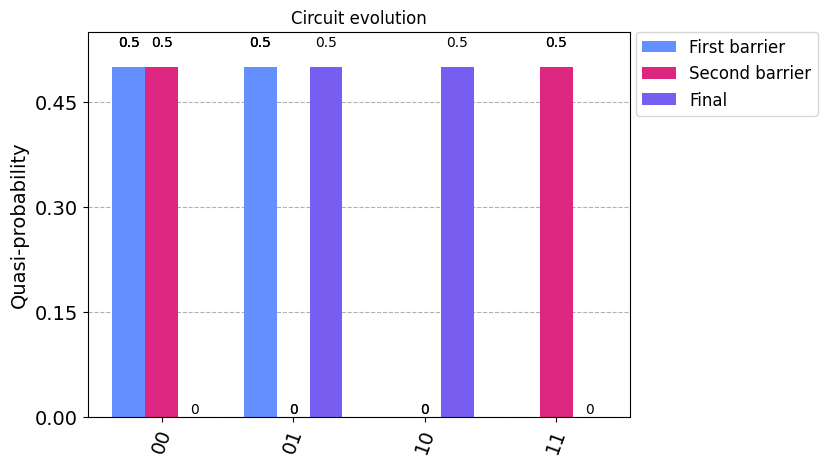

In [7]:
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram


statevector_1 = Statevector(c12_result.data()['sv1'])
statevector_2 = Statevector(c12_result.data()['sv2'])
statevector_final = Statevector(c12_result.get_statevector())


probability_1 = statevector_1.probabilities_dict()
probability_2 = statevector_2.probabilities_dict()
probability_final = statevector_final.probabilities_dict()


labels = ['First barrier', 'Second barrier', 'Final']
plot_histogram([probability_1, probability_2, probability_final], legend = labels, title="Circuit evolution")

A different way to get the mid-circuit state vector and density matrix is by using the methods `get_mid_density_matrix()` and `get_mid_statevector()` from the `C12SimJob` class.

These methods return `DensityMatrix` and `Statevector` instances, respectively.

In [8]:
# Attention! job is the instance obtained from the search, so it doesn't have any results stored, so we need to call result() function
# see notebook 3 for more information
c12_job.result()
statevecotor_1 = c12_job.get_mid_statevector(1)
density_matrix_1 = c12_job.get_mid_density_matrix(1)

print(statevector_1)
print(density_matrix_1)

Statevector([0.50000102+0.j, 0.49999898+0.j, 0.        +0.j,
             0.        +0.j],
            dims=(2, 2))
DensityMatrix([[0.50000102+0.00000000e+00j, 0.49998504-3.58175744e-07j,
                0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
               [0.49998504+3.58175744e-07j, 0.49999898+0.00000000e+00j,
                0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
               [0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
                0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
               [0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
                0.        +0.00000000e+00j, 0.        +0.00000000e+00j]],
              dims=(2, 2))


In [9]:
# If we try to get the results from the non-existing barrier we will get None as a result
print(c12_job.get_mid_statevector(15))

None


#### Visualization of the states

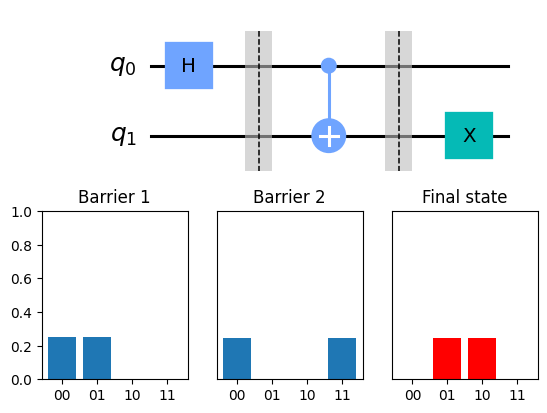

In [10]:
from qiskit.visualization import circuit_drawer
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig= plt.figure()

gs = GridSpec(2, 3)

ax1 = plt.subplot(gs[0, :])

circ_fig = circuit_drawer(orig_circuit, output='mpl', ax=ax1)

keys = {'00' : 0, '01' : 0, '10' : 0 , '11' : 0 }

ax2 = plt.subplot(gs[1,0])
ax2.set_ylim([0,1])
ax2.title.set_text('Barrier 1')
ax2_data = {**keys, **probability_1}
ax2.bar(ax2_data.keys(), ax2_data.values())

ax3 = plt.subplot(gs[1,1])
ax3.set_ylim([0,1])
ax3.set_yticks(())
ax3.title.set_text('Barrier 2')
ax3_data = {**keys, **probability_2}
ax3.bar(ax3_data.keys(), ax3_data.values())

ax4 = plt.subplot(gs[1,2])
ax4.set_ylim([0,1])
ax4.set_yticks(())
ax4.title.set_text('Final state')
ax4_data = {**keys, **probability_final}
ax4.bar(ax4_data.keys(), ax4_data.values(), color='red')


plt.show()